# 1. 라이브러리 임포트 및 데이터 준비

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:
        return Compose([
                        HorizontalFlip(p=0.5),
                        RandomSizedCrop(
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(
                            width=224,
                            height=224
                            )
                        ])
    return Compose([
                Resize(
                    width=224,
                    height=224
                    )
                ])


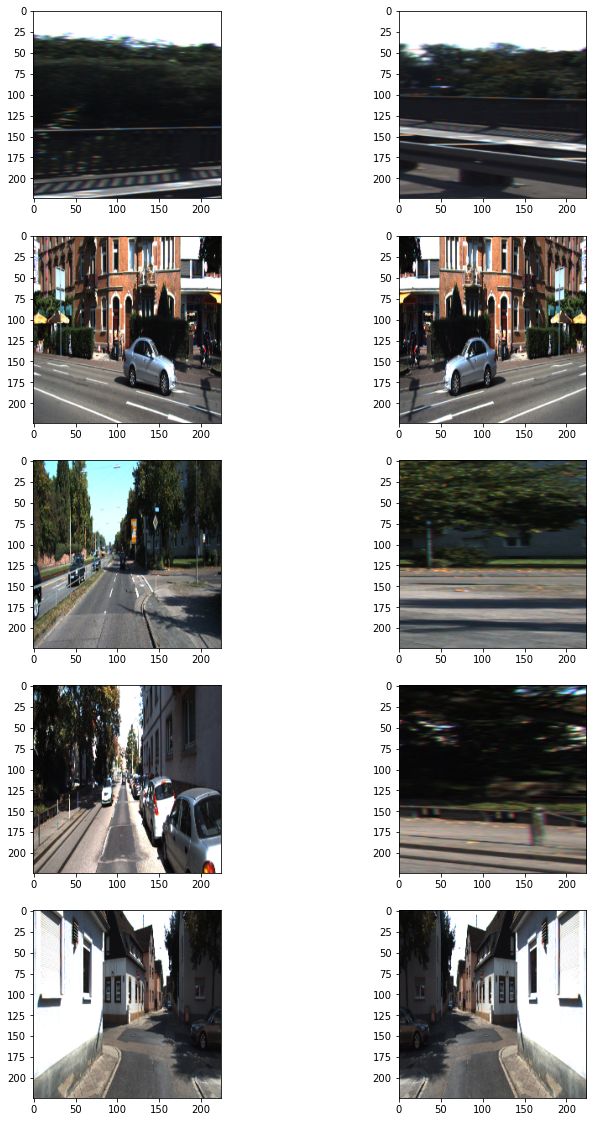

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"]) 
  
plt.show()


In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# 2. unet 모델링 및 학습

In [6]:
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
unet = build_unet()
unet.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_path = dir_path + '/seg_model_unet.h5'
unet.save(unet_path)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
43/43 [==============================] - 7s 169ms/step - loss: 0.5266 - val_loss: 0.1415
Epoch 2/100
43/43 [==============================] - 7s 164ms/step - loss: 0.1323 - val_loss: 0.1047
Epoch 3/100
43/43 [==============================] - 7s 169ms/step - loss: 0.0972 - val_loss: 0.0966
Epoch 4/100
43/43 [==============================] - 7s 170ms/step - loss: 0.0876 - val_loss: 0.0816
Epoch 5/100
43/43 [==============================] - 7s 159ms/step - loss: 0.0939 - val_loss: 0.1036
Epoch 6/100
43/43 [==============================] - 7s 169ms/step - loss: 0.0829 - val_loss: 0.0862
Epoch 7/100
43/43 [==============================] - 7s 165ms/step - loss: 0.0988 - val_loss: 0.0774
Epoch 8/100
43/43 [==============================] - 7s 160ms/step - loss: 0.0734 - val_loss: 0.0762
Epoch 9/100
43/43 [==============================] - 7s 166ms/step - loss: 0.0668 - val_loss: 0.0797
Epoch 10/100
43

43/43 [==============================] - 7s 165ms/step - loss: 0.0318 - val_loss: 0.0405
Epoch 77/100
43/43 [==============================] - 7s 165ms/step - loss: 0.0393 - val_loss: 0.0560
Epoch 78/100
43/43 [==============================] - 7s 165ms/step - loss: 0.0337 - val_loss: 0.0389
Epoch 79/100
43/43 [==============================] - 7s 167ms/step - loss: 0.0337 - val_loss: 0.0382
Epoch 80/100
43/43 [==============================] - 7s 168ms/step - loss: 0.0418 - val_loss: 0.0487
Epoch 81/100
43/43 [==============================] - 7s 167ms/step - loss: 0.0315 - val_loss: 0.0504
Epoch 82/100
43/43 [==============================] - 7s 171ms/step - loss: 0.0364 - val_loss: 0.0473
Epoch 83/100
43/43 [==============================] - 7s 168ms/step - loss: 0.0359 - val_loss: 0.0452
Epoch 84/100
43/43 [==============================] - 7s 168ms/step - loss: 0.0313 - val_loss: 0.0586
Epoch 85/100
43/43 [==============================] - 7s 166ms/step - loss: 0.0350 - val_loss: 

# 3. 결과 시각화 및 IOU 계산

In [ ]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
    
i = 1
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [8]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [9]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255 
    prediction = output/255
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1

        return output, prediction, target
    else:
        return output, prediction, _

In [11]:
i = 1 . 
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.849856


0.8498563721712324

# 5. Unet++ 모델링 및 학습

In [18]:
def build_unetpp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    x00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    x00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x00)
    p0 = MaxPooling2D(pool_size=(2, 2))(x00)
    
    x10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(p0)
    x10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x10)
    p1 = MaxPooling2D(pool_size=(2, 2))(x10)

    x01 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x10)
    x01 = concatenate([x00,x01], axis = 3)
    x01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x01)
    x01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x01)
    
    x20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(p1)
    x20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x20)
    p2 = MaxPooling2D(pool_size=(2, 2))(x20)

    x11 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x20)
    x11 = concatenate([x10,x11], axis = 3)
    x11 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x11)
    x11 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x11)

    x02 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x11)
    x02 = concatenate([x00, x01, x02], axis = 3)
    x02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x02)
    x02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x02)

    x30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(p2)
    x30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x30)
    p3 = MaxPooling2D(pool_size=(2, 2))(x30)
    

    x21 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x30)
    x21 = concatenate([x20,x21], axis = 3)
    x21 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x21)
    x21 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x21)
    
    x12 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x21)
    x12 = concatenate([x10, x11, x12], axis = 3)
    x12 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x12)
    x12 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x12) 

    x03 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x12)
    x03 = concatenate([x00, x01, x02, x03], axis = 3)
    x03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x03)
    x03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x03)


    x40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(p3)
    x40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x40)
    
    x31 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x40)
    x31 = concatenate([x31, x30], axis = 3)
    x31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x31)
    x31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x31)

    x22 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x31)
    x22 = concatenate([x22, x20, x21], axis = 3)
    x22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x22)
    x22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x22)

    x13 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x22)
    x13 = concatenate([x13, x10, x11, x12], axis = 3)
    x13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x13)
    x13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x13) 

    x04 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(x13)
    x04 = concatenate([x04, x00, x01, x02, x03], axis = 3)
    x04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x04)
    x04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x04)
    output = Conv2D(1, 1, activation='sigmoid')(x04)
    model = Model(inputs = inputs, outputs = output)
    return model

In [19]:
unetpp = build_unetpp()
unetpp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unetpp.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unetpp_path = dir_path + '/seg_model_unetpp.h5'
unetpp.save(unet_path)

Epoch 1/100
43/43 [==============================] - 13s 312ms/step - loss: 0.4735 - val_loss: 0.1241
Epoch 2/100
43/43 [==============================] - 13s 304ms/step - loss: 0.1252 - val_loss: 0.1171
Epoch 3/100
43/43 [==============================] - 13s 310ms/step - loss: 0.1064 - val_loss: 0.0958
Epoch 4/100
43/43 [==============================] - 14s 320ms/step - loss: 0.0948 - val_loss: 0.0979
Epoch 5/100
43/43 [==============================] - 13s 313ms/step - loss: 0.0929 - val_loss: 0.0854
Epoch 6/100
43/43 [==============================] - 13s 313ms/step - loss: 0.0731 - val_loss: 0.0874
Epoch 7/100
43/43 [==============================] - 14s 322ms/step - loss: 0.0607 - val_loss: 0.0676
Epoch 8/100
43/43 [==============================] - 14s 328ms/step - loss: 0.0611 - val_loss: 0.0667
Epoch 9/100
43/43 [==============================] - 14s 323ms/step - loss: 0.0570 - val_loss: 0.0600
Epoch 10/100
43/43 [==============================] - 14s 314ms/step - loss: 0.055

KeyboardInterrupt: 

# 6. Unet++ 결과 iou score

In [21]:
i = 1
output, prediction, target = get_output(
     unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.771728


0.7717283950617284

# 7. 결과 정리
- Unet 모델과 Unet++ 모델을 만들고 학습을 진행하였습니다.
- Unet 모델을 100에폭 학습 후 첫 번째 데이터로 iou 스코어 계산 시 0.849856 정도의 결과를 얻었습니다.
- Unet++ 모델의 경우 100에폭까지 학습을 진행하려고 하였으나 시간 관계상 중간에 중단하였습니다. 하지만 기존의 Unet모델 보다 약간 더 빠르고, 더 아래로 비용이 감소하는 것을 확인 할 수 있었으며, iou 스코어 계산시 0.771728 결과를 얻었습니다.